In [1]:
import nibabel as nib
from matplotlib import pyplot as plt
import os
import pickle
import numpy as np
import seaborn as sns

#NN
import tensorflow as tf
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers

# Metrics
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# GPU
from tensorflow.python.client import device_lib

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\framework\dty

In [2]:
# Check GPU Detected
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1532826166145513418
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7129487770
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10972445399284188843
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


## Functions

In [3]:
def showImage(img, title):
    plt.imshow(img, cmap = "gray", origin = 'upper')
    plt.title(title), plt.xticks([]), plt.yticks([])
    plt.show()

In [4]:
#https://medium.com/@aakashgoel12/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d#:~:text=By%20default,%20f1%20score%20is%20not%20part%20of,each%20epoch,%20need%20to%20make%20some%20more%20efforts.
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [5]:
def matthews_correlation(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

In [6]:
#https://github.com/mkocabas/focal-loss-keras/blob/master/focal_loss.py
gamma = 2
alpha = .25
def focal_loss_fixed(y_true, y_pred):
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

## Grouping Files into Datasets

In [7]:
#base_path="C:/Users/drago/Documents/gitrepos/individual-project-alzhiemers_detection/MRI Data/WM parc data - cropped images/Blur_Contour_Crop/"
base_path="C:/Users/matth/OneDrive - University of Reading/Documents/Year 3 Documents/Final Year Project/Git Large File Storage/MRI Data/WM parc data - cropped images/"
data = base_path + "ExpandedCrop_Square_Hist_NewSplit_OSampled/"
cross_val = base_path + "Blur_Contour_Expand_Crop-Cats_Combined/"

In [8]:
# Break:
# 196 : 97 : 97
# 359 : 178 : 178

In [9]:
# Cross val dataset check
train_size = len(os.listdir(data + "1-Train/1-AD"))+len(os.listdir(data + "1-Train/0-CN"))
valid_size = len(os.listdir(data + "2-Validation/1-AD"))+len(os.listdir(data + "2-Validation/0-CN"))
test_size = len(os.listdir(data + "3-Test/1-AD"))+len(os.listdir(data + "3-Test/0-CN"))

cv_val_size = len(os.listdir(cross_val + "Cross_Val/1-AD"))+len(os.listdir(cross_val + "Cross_Val/0-CN"))
cv_test_size = len(os.listdir(cross_val + "Test/1-AD"))+len(os.listdir(cross_val + "Test/0-CN"))


print("Total Training Data: ", train_size)
print("Total Validation Data: ", valid_size)
print("Total Test Data: ", test_size)

print("\nTotal Cross Validation Data: ", cv_val_size)
print("Total Test Data: ", cv_test_size)

Total Training Data:  1146
Total Validation Data:  142
Total Test Data:  142

Total Cross Validation Data:  829
Total Test Data:  276


In [10]:
batch_size = 32

# Build from directory dataset generators
train_aug_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=7,
    width_shift_range=0.01,
    height_shift_range=0.01,
    zoom_range=[1-0.01, 1+0.01],
    #threshold
    fill_mode='nearest')

test_aug_datagen = ImageDataGenerator(rescale=1./255)

"""
cross_val_aug_generator = train_aug_datagen.flow_from_directory(
    cross_val + "Cross_Val/",
    target_size=(256,256),
    batch_size=batch_size,
    class_mode="binary")
"""

# Augmented generators for fitting and fine tuning 'best' model
train_aug_generator = train_aug_datagen.flow_from_directory(
    data+"1-Train/",
    target_size=(256,256),
    batch_size=batch_size,
    class_mode="binary")

validation_aug_generator = test_aug_datagen.flow_from_directory(
    data+"2-Validation/",
    target_size=(256,256),
    batch_size=batch_size,
    class_mode="binary")


test_aug_generator = test_aug_datagen.flow_from_directory(
    data+"3-Test/",
    target_size=(256,256),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False)

Found 1146 images belonging to 2 classes.
Found 142 images belonging to 2 classes.
Found 142 images belonging to 2 classes.


## Feature Extraction

### Data Preprosessing

## Construct Model Function

In [11]:
# Construct model
def construct_model(vgg = 0, num_layers = 2, dense_size = 128, drop_layers = 0, dropout_val = .4, 
                    current_optimizer = "Adam", current_lr = 8e-05):
    #param: current_metrics = "f1"
    augmentedVGG16 = models.Sequential()
    
    if vgg:
        conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
        augmentedVGG16.add(conv_base)
        conv_base.trainable=False
        augmentedVGG16.add(layers.Flatten())
        augmentedVGG16.add(layers.Dense(dense_size, kernel_regularizer=regularizers.l2(.001), activation='relu'))
    else:
        augmentedVGG16.add(layers.Dense(dense_size, activation='relu', input_dim=8*8*512))
    
    if drop_layers:
        augmentedVGG16.add(layers.Dropout(dropout_val))
    
    if num_layers == 3:
        augmentedVGG16.add(layers.Dense(dense_size, activation='relu'))
        if drop_layers:
            augmentedVGG16.add(layers.Dropout(dropout_val))
        
    augmentedVGG16.add(layers.Dense(1, kernel_regularizer=regularizers.l2(.001), activation='sigmoid'))

    # Freeze CNN
    #conv_base.trainable=False

    # Optimiser
    if current_optimizer == "RMSprop":
        optim = optimizers.RMSprop(lr=current_lr)
    elif current_optimizer == "Adam":
        optim = optimizers.Adam(lr=current_lr)
    
    # Model Compile
    #, tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), get_f1, matthews_correlation
    augmentedVGG16.compile(optimizer=optim, loss=focal_loss_fixed, metrics = ['acc'])
    
    return augmentedVGG16

### Fit Model with Best Hyperparameters

In [12]:
# Model Compile
augmentedVGG16 = construct_model(vgg = 1, num_layers=2, dense_size=64, current_lr=5e-6, current_optimizer="Adam", 
                                 drop_layers=1)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Fitting and Saving Model

In [13]:
base_directory = "C:/Users/matth/OneDrive - University of Reading/Documents/Year 3 Documents/Final Year Project/Git Large File Storage/Models/three-slice-data/VGG16_Fit_3slice_reg_classWeights - 3_2/"
best_model_file = base_directory + "best_model.hdf5"
history_file_name = base_directory + "History.pkl"
info_file_name = base_directory + "README.md"
model_content = """Base: VGG16
Drop out = 1
Dropout val = 0.4
Dense: 2
Dense Size: 64
Regularised Dense Layer = true
Reg Layer 2: .001
Augmentation: 7 degree, width_shift: 0.01, height_shift: 0.01, zoom_range: [1-0.01, 1+0.01]
Image Size: 256
Batch_size:32
valid steps: 50
Optimizer: Adam
Lr: 5e-6
Loss: Focal Loss Fixed
Metric: 'acc'
Epochs: 100
Data 0-CN, 1-AD => train:valid:test | 80:10:10 | AD Oversampled
"""
#, tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), get_f1, matthews_correlation

with open(info_file_name, 'w') as readme_file:
       readme_file.write(model_content)

In [14]:
# weights = compute_class_weight('balanced', np.unique(train_aug_generator.classes), train_aug_generator.classes)
# weights = {0: weights[0], 1: weights[1]}

# Create checkpoint callback to store best acc to loss model
checkpoint = ModelCheckpoint(filepath=best_model_file, save_best_only=True)

# Fit model
#### Change to Fit
VGG16_history = augmentedVGG16.fit_generator(train_aug_generator, 
                                             steps_per_epoch=100, 
                                             epochs=100, 
                                             callbacks=[checkpoint], 
                                             validation_data=validation_aug_generator,
                                             validation_steps=50)
save_history = VGG16_history.history
# Save history
with open(history_file_name, 'wb') as file_pi:
        pickle.dump(save_history, file_pi)

Epoch 1/100
100/100 [==============================] - 54s 539ms/step - loss: 0.2329 - acc: 0.4931 - val_loss: 0.1945 - val_acc: 0.4859
Epoch 2/100
100/100 [==============================] - 51s 515ms/step - loss: 0.1967 - acc: 0.5373 - val_loss: 0.1850 - val_acc: 0.5141
Epoch 3/100
100/100 [==============================] - 49s 491ms/step - loss: 0.1823 - acc: 0.5380 - val_loss: 0.1786 - val_acc: 0.5141
Epoch 4/100
100/100 [==============================] - 49s 491ms/step - loss: 0.1725 - acc: 0.5679 - val_loss: 0.1704 - val_acc: 0.5141
Epoch 5/100
100/100 [==============================] - 50s 498ms/step - loss: 0.1645 - acc: 0.5823 - val_loss: 0.1654 - val_acc: 0.5986
Epoch 6/100
100/100 [==============================] - 52s 522ms/step - loss: 0.1565 - acc: 0.6091 - val_loss: 0.1581 - val_acc: 0.6056
Epoch 7/100
100/100 [==============================] - 50s 503ms/step - loss: 0.1508 - acc: 0.6270 - val_loss: 0.1537 - val_acc: 0.6197
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 48s 482ms/step - loss: 0.0561 - acc: 0.9472 - val_loss: 0.1107 - val_acc: 0.8239
Epoch 62/100
100/100 [==============================] - 47s 470ms/step - loss: 0.0556 - acc: 0.9459 - val_loss: 0.1089 - val_acc: 0.8310
Epoch 63/100
100/100 [==============================] - 47s 472ms/step - loss: 0.0545 - acc: 0.9522 - val_loss: 0.1077 - val_acc: 0.8310
Epoch 64/100
100/100 [==============================] - 47s 470ms/step - loss: 0.0545 - acc: 0.9535 - val_loss: 0.1112 - val_acc: 0.8169
Epoch 65/100
100/100 [==============================] - 49s 494ms/step - loss: 0.0540 - acc: 0.9504 - val_loss: 0.1004 - val_acc: 0.8310
Epoch 66/100
100/100 [==============================] - 49s 488ms/step - loss: 0.0534 - acc: 0.9557 - val_loss: 0.1150 - val_acc: 0.8239
Epoch 67/100
100/100 [==============================] - 48s 477ms/step - loss: 0.0530 - acc: 0.9535 - val_loss: 0.1077 - val_acc: 0.8239
Epoch 68/100
100/100 [===================

### Retrieving Saved Model and History

In [15]:
# Get history
with open(history_file_name, 'rb') as file__pi:
    VGG16_history = pickle.load(file__pi)
    
# Get best model
VGG16_best = models.load_model(best_model_file, custom_objects={"focal_loss_fixed": focal_loss_fixed, "get_f1": get_f1, "matthews_correlation": matthews_correlation})
#Temp for unused metrics
#, "get_f1": get_f1, "matthews_correlation": matthews_correlation

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [16]:
validation_aug_generator = test_aug_datagen.flow_from_directory(
    data+"2-Validation/",
    target_size=(256,256),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False)

Found 142 images belonging to 2 classes.


### Plotting Results

In [17]:
accuracy = VGG16_history['acc']
validation_accuracy = VGG16_history['val_acc']

loss = VGG16_history['loss']
validation_loss = VGG16_history['val_loss']
"""
precision = VGG16_augmented_history.history['precision']
validation_precision = VGG16_augmented_history.history['val_precision']
recall = VGG16_augmented_history.history['recall']
validation_recall = VGG16_augmented_history.history['val_recall']
f1 = VGG16_augmented_history.history['get_f1']
validation_f1 = VGG16_augmented_history.history['val_get_f1']
mcc = VGG16_augmented_history.history['matthews_correlation']
validation_mcc = VGG16_augmented_history.history['val_matthews_correlation']
"""

"\nprecision = VGG16_augmented_history.history['precision']\nvalidation_precision = VGG16_augmented_history.history['val_precision']\nrecall = VGG16_augmented_history.history['recall']\nvalidation_recall = VGG16_augmented_history.history['val_recall']\nf1 = VGG16_augmented_history.history['get_f1']\nvalidation_f1 = VGG16_augmented_history.history['val_get_f1']\nmcc = VGG16_augmented_history.history['matthews_correlation']\nvalidation_mcc = VGG16_augmented_history.history['val_matthews_correlation']\n"


valid_acc:  0.85915494
valid_loss:  0.08195793107151986


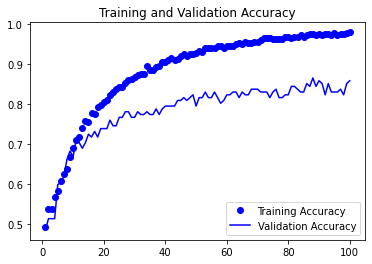

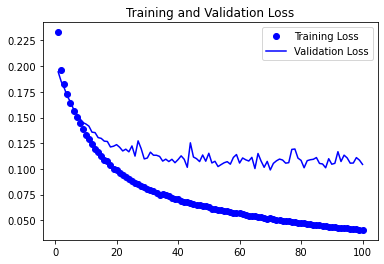

<Figure size 432x288 with 0 Axes>

In [22]:
epochs = range(1, len(accuracy) + 1)

# Accuracy Plots
plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.legend()

plt.figure()

# Loss Plots
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, validation_loss, 'b', label='Validation Loss')
plt.title("Training and Validation Loss")
plt.legend()

plt.figure()

# Generate acc loss percentages
#, valid_precision, valid_recall, valid_f1, valid_mcc
test_loss, test_acc = VGG16_best.evaluate_generator(test_aug_generator, steps=len(test_aug_generator))
print("\nvalid_acc: ", test_acc)
print("valid_loss: ", test_loss)
#print("valid_precision: ", valid_precision)
#print("valid_recall: ", valid_recall)
#print("valid_f1: ", valid_f1)
#print("valid_mcc: ", valid_mcc)

In [23]:
# Classification metric matrix: precision, recall, f1-score, support
test_preds = np.round(VGG16_best.predict_generator(test_aug_generator),0)
test_trues = test_aug_generator.classes

# Label data
classes = list(test_aug_generator.class_indices.keys())

print(classification_report(test_trues, test_preds, target_names=classes))

              precision    recall  f1-score   support

        0-CN       0.93      0.77      0.85        71
        1-AD       0.81      0.94      0.87        71

    accuracy                           0.86       142
   macro avg       0.87      0.86      0.86       142
weighted avg       0.87      0.86      0.86       142



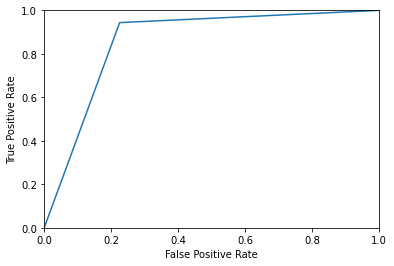

Area Under ROC: 0.8591549295774648


In [24]:
false_pos_rt, true_pos_rt, _ = roc_curve ( test_trues , test_preds)

plt.plot(false_pos_rt,true_pos_rt) 
plt.axis([0,1,0,1]) 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.show()

print("Area Under ROC: {}".format(roc_auc_score(test_trues,test_preds)))

Confusion Matrix


<AxesSubplot:>

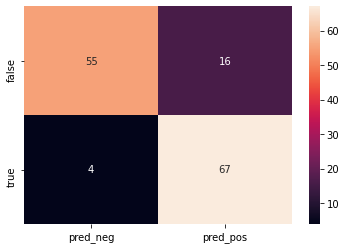

In [25]:
conf_mat = confusion_matrix(test_trues, test_preds)

print("Confusion Matrix")
sns.heatmap(conf_mat, annot=True, xticklabels=["pred_neg", "pred_pos"], yticklabels=["false", "true"])

## Fine Tuning Model

In [20]:
base_directory = "C:/Users/matth/OneDrive - University of Reading/Documents/Year 3 Documents/Final Year Project/Git Large File Storage/Models/three-slice-data/VGG16_Fit_77%_3slice_dropout_adam - 3_2/"
best_model_file = base_directory + "best_model.hdf5"
history_file_name = base_directory + "History.pkl"
info_file_name = base_directory + "README.md"
model_content = """Base: VGG16
Drop out = 1
Dropout val = 0.5
Dense: 2
Dense Size: 256
Augmentation: 7 degree, width_shift: 0.01, height_shift: 0.01, zoom_range: [1-0.01, 1+0.01]
Image Size: 256
Batch_size:32
Optimizer: Adam
Lr: 1e-6
Loss: Focal Loss Fixed
Metric: 'acc', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), get_f1, matthews_correlation
Epochs: 100
FineTuning
"""

with open(info_file_name, 'w') as readme_file:
       readme_file.write(model_content)

### Reshuffle validation data

In [21]:
validation_aug_generator = test_aug_datagen.flow_from_directory(
    base_path+"2-Validation/",
    target_size=(256,256),
    batch_size=batch_size,
    class_mode="binary")

Found 276 images belonging to 2 classes.


### Set trainable higher layers

In [22]:
VGG16_best.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               8388864   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 23,103,809
Trainable params: 8,389,121
Non-trainable params: 14,714,688
_________________________________________________________________


In [23]:
vgg16_base = VGG16_best.get_layer(name="vgg16")
vgg16_base.trainable = True

set_trainable = False
for layer in vgg16_base.layers:
    if layer.name == "block5_conv1":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
VGG16_best.get_layer(name="vgg16").summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

### Compile and fit

In [24]:
# Model Compile
VGG16_best.compile(optimizer=optimizers.Adam(lr=1e-7),
                         loss=focal_loss_fixed,
                         metrics=['acc', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), get_f1, matthews_correlation])

In [25]:
# Create checkpoint callback to store best acc to loss model
checkpoint = ModelCheckpoint(filepath=best_model_file, save_best_only=True)

# Fit model
VGG16_FT_history = VGG16_best.fit_generator(
    train_aug_generator,
    steps_per_epoch=100,
    epochs=100,
    callbacks=[checkpoint],
    validation_data=validation_aug_generator,
    validation_steps=32)

save_history = VGG16_FT_history.history
# Save history
with open(history_file_name, 'wb') as file_pi:
        pickle.dump(save_history, file_pi)

Epoch 1/100
100/100 [==============================] - 45s 452ms/step - loss: 0.0317 - acc: 0.8733 - precision_1: 0.9750 - recall_1: 0.8245 - get_f1: 0.8929 - matthews_correlation: 0.7582 - val_loss: 0.0613 - val_acc: 0.6670 - val_precision_1: 0.8253 - val_recall_1: 0.6144 - val_get_f1: 0.7020 - val_matthews_correlation: 0.3679
Epoch 2/100
100/100 [==============================] - 44s 440ms/step - loss: 0.0314 - acc: 0.8723 - precision_1: 0.9727 - recall_1: 0.8263 - get_f1: 0.8908 - matthews_correlation: 0.7516 - val_loss: 0.0623 - val_acc: 0.6721 - val_precision_1: 0.8369 - val_recall_1: 0.6113 - val_get_f1: 0.6985 - val_matthews_correlation: 0.3654
Epoch 3/100
100/100 [==============================] - 42s 420ms/step - loss: 0.0311 - acc: 0.8743 - precision_1: 0.9733 - recall_1: 0.8281 - get_f1: 0.8919 - matthews_correlation: 0.7538 - val_loss: 0.0624 - val_acc: 0.6741 - val_precision_1: 0.8376 - val_recall_1: 0.6184 - val_get_f1: 0.7059 - val_matthews_correlation: 0.3726
Epoch 4/10

Epoch 26/100
100/100 [==============================] - 43s 433ms/step - loss: 0.0234 - acc: 0.9180 - precision_1: 0.9838 - recall_1: 0.8879 - get_f1: 0.9322 - matthews_correlation: 0.8358 - val_loss: 0.0624 - val_acc: 0.6822 - val_precision_1: 0.8194 - val_recall_1: 0.6494 - val_get_f1: 0.7196 - val_matthews_correlation: 0.3790
Epoch 27/100
100/100 [==============================] - 42s 420ms/step - loss: 0.0247 - acc: 0.9089 - precision_1: 0.9792 - recall_1: 0.8773 - get_f1: 0.9213 - matthews_correlation: 0.8122 - val_loss: 0.0630 - val_acc: 0.6700 - val_precision_1: 0.8079 - val_recall_1: 0.6405 - val_get_f1: 0.7072 - val_matthews_correlation: 0.3414
Epoch 28/100
100/100 [==============================] - 41s 406ms/step - loss: 0.0233 - acc: 0.9167 - precision_1: 0.9860 - recall_1: 0.8836 - get_f1: 0.9290 - matthews_correlation: 0.8347 - val_loss: 0.0643 - val_acc: 0.6802 - val_precision_1: 0.8187 - val_recall_1: 0.6462 - val_get_f1: 0.7170 - val_matthews_correlation: 0.3760
Epoch 2

Epoch 51/100
  4/100 [>.............................] - ETA: 16s - loss: 0.0236 - acc: 0.9238 - precision_1: 0.9683 - recall_1: 0.9104 - get_f1: 0.9222 - matthews_correlation: 0.8321

KeyboardInterrupt: 

### Retrieving Saved Model and History

In [ ]:
with open(history_file_name, 'rb') as file__pi:
    VGG16_FT_history = pickle.load(file__pi)
    
VGG16_FT_best = models.load_model(best_model_file, custom_objects={"focal_loss_fixed": focal_loss_fixed, "get_f1": get_f1, "matthews_correlation": matthews_correlation})
# Temp Comment out
# , "get_f1": get_f1, "matthews_correlation": matthews_correlation

### Plotting Results

In [ ]:
validation_aug_generator = test_aug_datagen.flow_from_directory(
    base_path+"2-Validation/",
    target_size=(256,256),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False)

In [ ]:
accuracy = VGG16_FT_history['acc']
validation_accuracy = VGG16_FT_history['val_acc']

loss = VGG16_FT_history['loss']
validation_loss = VGG16_FT_history['val_loss']

"""
precision = VGG16_augmented_fine_tune_history['precision_1']
validation_precision = VGG16_augmented_fine_tune_history['val_precision_1']
recall = VGG16_augmented_fine_tune_history['recall_1']
validation_recall = VGG16_augmented_fine_tune_history['val_recall_1']
f1 = VGG16_augmented_fine_tune_history['get_f1']
validation_f1 = VGG16_augmented_fine_tune_history['val_get_f1']
mcc = VGG16_augmented_fine_tune_history['matthews_correlation']
validation_mcc = VGG16_augmented_fine_tune_history['val_matthews_correlation']
"""

In [ ]:
epochs = range(1, len(accuracy) + 1)


# Accuracy Plots
plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.legend()

plt.figure()

# Loss Plots
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, validation_loss, 'b', label='Validation Loss')
plt.title("Training and Validation Loss")
plt.legend()

plt.figure()

# Generate acc loss percentages
best_loss, best_acc, best_precision, best_recall, best_f1, best_mcc = VGG16_FT_best.evaluate_generator(
                                                                                validation_aug_generator, 
                                                                                steps=len(validation_aug_generator))
#, best_precision, best_recall, best_f1, best_mcc
print("\nbest_acc: ", best_acc)
print("best_loss: ", best_loss)
print("best_precision: ", best_precision)
print("best_recall: ", best_recall)
print("best_f1: ", best_f1)
print("best_mcc: ", best_mcc)

### Testing
# Output best epoch acc loss percentages
test_loss, test_acc, valid_precision, valid_recall, valid_f1, valid_mcc = VGG16_FT_best.evaluate_generator(
                                                                                    test_aug_generator,
                                                                                    steps=len(test_aug_generator))

print("\ntest_acc: ", test_acc)
print("test_loss: ", test_loss)
print("test_precision: ", test_precision)
print("test_recall: ", test_recall)
print("test_f1: ", test_f1)
print("test_mcc: ", test_mcc)

In [ ]:
# Classification metric matrix: precision, recall, f1-score, support
val_preds = np.round(VGG16_FT_best.predict_generator(validation_aug_generator, steps=len(validation_aug_generator)),0)
val_trues = validation_aug_generator.classes

# Label data
classes = np.array(list(validation_aug_generator.class_indices.keys()))

print(classification_report(val_trues, val_preds, target_names = classes))

In [ ]:
test_preds = np.round(VGG16_FT_best.predict_generator(test_aug_generator, steps=len(test_aug_generator)),0)
test_trues = test_aug_generator.classes

# Label data
classes = np.array(list(test_aug_generator.class_indices.keys()))

print(classification_report(test_trues, test_preds, target_names = classes))